<a href="https://colab.research.google.com/github/m1chae11u/Deep-CNN-2D-Floor-Plan-Classifier/blob/main/Deep_CNN_Image_Classifier_For_2D_Room_Layouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [4]:
import tensorflow as tf
import os

# import zipfile
# zip_path = '/content/ezyzip.zip'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content')

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU') #shows all gpus available
#this is telling tensorflow to limit the memory consumption
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Remove Bad Images**

In [6]:
import cv2
import imghdr

In [9]:
!rm '/content/data/.DS_Store'
data_dir = '/content/data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/data/2d-office-spaces/8cff04e3ac2b4d0d8b0c3e154fd3fb77.webp
Image not in ext list /content/data/2d-office-spaces/.DS_Store
Image not in ext list /content/data/2d-office-spaces/CHOPTANK-CONFERENCE-16.jpg
Image not in ext list /content/data/2d-living-spaces/518d6095b4e092bda51d35169c5f3b98.gif
Image not in ext list /content/data/2d-living-spaces/.DS_Store
Image not in ext list /content/data/2d-living-spaces/0f9927d4f1226162f619204b9a1d260bb2a2ba6a_2_666x500.gif
Image not in ext list /content/data/2d-living-spaces/s-l12002.webp
Image not in ext list /content/data/2d-living-spaces/a5df11186097009.Y3JvcCw1MDAwLDM5MTAsMCwyOTc.jpg
Image not in ext list /content/data/2d-living-spaces/4871-1stfloor.webp
Image not in ext list /content/data/2d-living-spaces/30253240223_d92127d7ef_z.jpg
Image not in ext list /content/data/2d-living-spaces/top-view-plan.gif


Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
#building data pipeline
data = tf.keras.utils.image_dataset_from_directory('/content/data')

Found 1083 files belonging to 3 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

In [15]:
batch[0].shape

(32, 256, 256, 3)

In [16]:
# Class 1 = 2D Office Spaces
# Class 0 = 2D Living Spaces
batch[1]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1], dtype=int32)

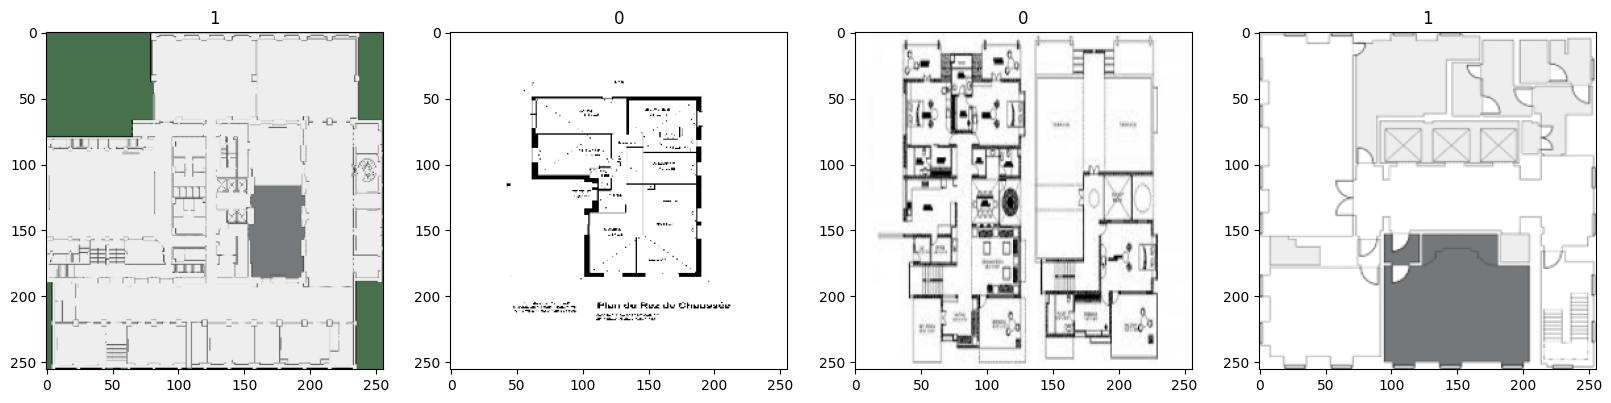

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

# **Preprocess Data**

In [18]:
#scaling the data
data = data.map(lambda x,y: ((x/255), y)) #scales all the pixel values to between 0 and 1, map function allows us to apply the scaling transformation as the data is accessed.

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.47585785, 0.47585785, 0.47585785],
          [0.47320148, 0.47320148, 0.47320148],
          [0.4709554 , 0.4709554 , 0.4709554 ],
          ...,
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ]],
 
         [[0.49322918, 0.49322918, 0.49322918],
          [0.50370616, 0.50370616, 0.50370616],
          [0.5080475 , 0.5080475 , 0.5080475 ],
          ...,
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ]],
 
         [[0.49859068, 0.49859068, 0.49859068],
          [0.51025486, 0.51025486, 0.51025486],
          [0.5126718 , 0.5126718 , 0.5126718 ],
          ...,
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ],
          [0.49411765, 0.49411765, 0.5019608 ]],
 
         ...,
 
         [[0.49583334, 0.49583334, 0.49583334],
          [0.49446

In [20]:
#splitting data into training, validation, and test partition
train_size = int(len(data)*.7) #used to train our model
val_size = int(len(data)*.2) + 1 #used to evaluate our model during training and fine tune
test_size = int(len(data)*.1) + 1 #used for post training evaluation
print(len(data) == (train_size + val_size + test_size))

True


In [21]:
#data is already shuffled
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
print(len(data) == len(train) + len(val) + len(test))

True


# **Building The Deep Learning Model**

In [22]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

In [23]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

model = Sequential([
    data_augmentation,  # Data augmentation layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 256, 256, 3))  # Explicitly building the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)     

# **Training**

In [24]:
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

hist = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[tensorboard_callback, reduce_lr]
)

Epoch 1/30
23/23 [==============================] - 238s 10s/step - loss: 1.1490 - accuracy: 0.6562 - val_loss: 0.6394 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 228s 10s/step - loss: 0.7027 - accuracy: 0.7038 - val_loss: 0.9853 - val_accuracy: 0.4509 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 239s 10s/step - loss: 0.6824 - accuracy: 0.6603 - val_loss: 1.5673 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.7310
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
23/23 [==============================] - 230s 10s/step - loss: 0.5863 - accuracy: 0.7310 - val_loss: 2.6722 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 243s 10s/step - loss: 0.5281 - accuracy: 0.7486 - val_loss: 2.5258 - val_accuracy: 0.4732 - lr: 2.0000e-04
Epoch 6/30
23/23 [==============================] - 234s 10s/

# **Plot Performance**

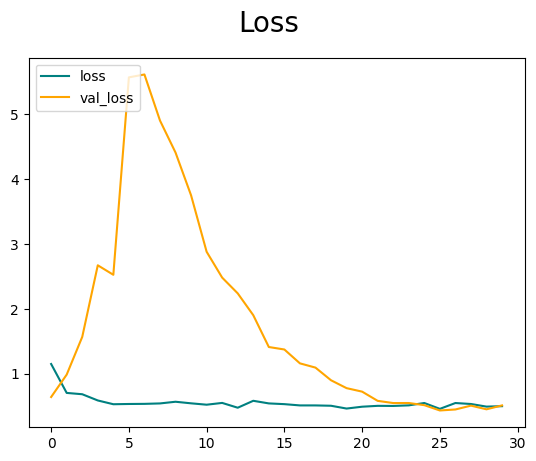

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

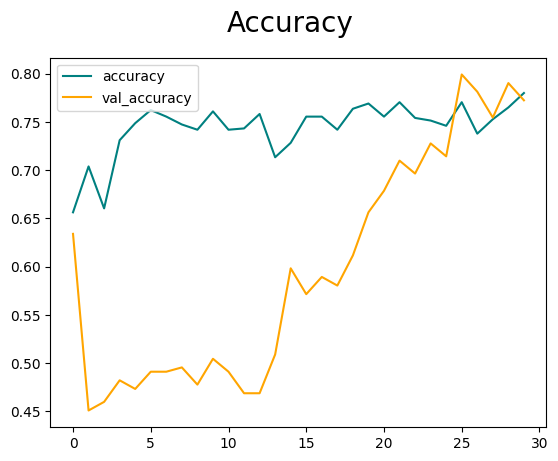

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate**

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
precs = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precs.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [29]:
print(f'Precision: {precs.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7746478915214539, Recall: 0.7746478915214539, Accuracy: 0.7398374080657959


# **Test**

In [33]:
imgliving1 = cv2.imread('/content/data/test/test-livingspace1.jpg')
imgliving2 = cv2.imread('/content/data/test/test-livingspace2.jpg')
imgoffice1 = cv2.imread('/content/data/test/test-office1.jpg')
imgoffice2 = cv2.imread('/content/data/test/test-office2.jpg')

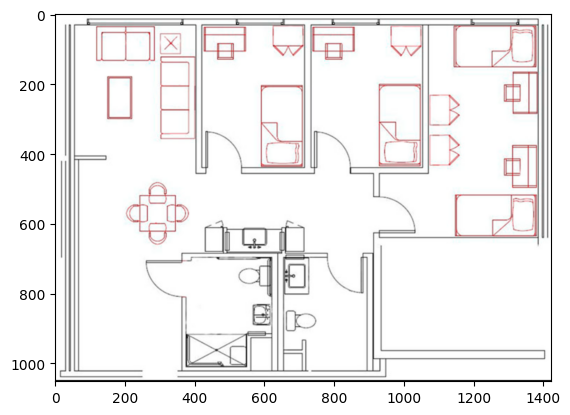

In [34]:
plt.imshow(imgliving1)
plt.show()

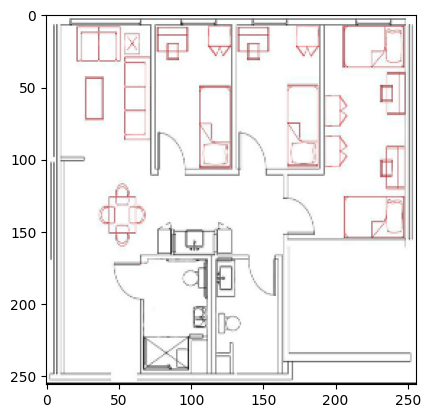

In [35]:
resize_imgliving1 = tf.image.resize(imgliving1, (256, 256))
resize_imgliving2 = tf.image.resize(imgliving2, (256, 256))
resize_imgoffice1 = tf.image.resize(imgoffice1, (256, 256))
resize_imgoffice2 = tf.image.resize(imgoffice2, (256, 256))

plt.imshow(resize_imgliving1.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize_imgliving1, 0)
np.expand_dims(resize_imgliving2, 0)
np.expand_dims(resize_imgoffice1, 0)
np.expand_dims(resize_imgoffice2, 0)

In [37]:
yhat_living1 = model.predict(np.expand_dims(resize_imgliving1/255, 0))
yhat_living2 = model.predict(np.expand_dims(resize_imgliving2/255, 0))
yhat_office1 = model.predict(np.expand_dims(resize_imgoffice1/255, 0))
yhat_office2 = model.predict(np.expand_dims(resize_imgoffice2/255, 0))
print("Living Space = 0 \nOffice Space = 1")
print(f'Living Space Test #1: {yhat_living1[0][0]} \nLiving Space Test #2: {yhat_living2[0][0]} \nOffice Space Test #1: {yhat_office1[0][0]} \nOffice Space Test #2: {yhat_office2[0][0]}')

1/1 [==============================] - 0s 90ms/step
Living Space = 0 
Office Space = 1
Living Space Test #1: 0.508102536201477 
Living Space Test #2: 0.03981007635593414 
Office Space Test #1: 0.33966246247291565 
Office Space Test #2: 0.01537142414599657


future considerations: make sure that when preprocessing data, remove all color, otherwise the model may form biases.